# Part 6: LightGBMClassifier Model

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load Dataset

Please see the link to know more about the dataset: https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification#

In [2]:
features = ['tqwt_entropy_log_dec_33', 'tqwt_minvalue_dec_25',
 'tqwt_entropy_shannon_dec_25', 'tqwt_meanvalue_dec_36',
 'tqwt_kurtosisvalue_dec_33', 'tqwt_kurtosisvalue_dec_31',
 'tqwt_maxvalue_dec_17', 'std_9th_delta', 'tqwt_maxvalue_dec_13',
 'tqwt_entropy_log_dec_28', 'tqwt_tkeo_std_dec_19', 'tqwt_meanvalue_dec_22',
 'imf_snr_seo', 'tqwt_meanvalue_dec_5', 'tqwt_kurtosisvalue_dec_27', 'class']

df = pd.read_csv('preprocessed_speech_features.csv', usecols = features)
df.head()

,imf_snr_seo,std_9th_delta,tqwt_entropy_shannon_dec_25,tqwt_entropy_log_dec_28,tqwt_entropy_log_dec_33,tqwt_tkeo_std_dec_19,tqwt_meanvalue_dec_5,tqwt_meanvalue_dec_22,tqwt_meanvalue_dec_36,tqwt_minvalue_dec_25,tqwt_maxvalue_dec_13,tqwt_maxvalue_dec_17,tqwt_kurtosisvalue_dec_27,tqwt_kurtosisvalue_dec_31,tqwt_kurtosisvalue_dec_33,class
0,51.6843,0.047180,53.7314,-3160.3491,-4540.0830,0.063262,-3.980000e-22,-1.250000e-18,-0.014610,-0.24540,0.048924,0.46639,1.5466,4.2105,4.4625,1
1,24.0230,0.039071,35.3951,-3212.9726,-4466.8949,0.050015,0.000000e+00,-1.440000e-19,-0.013605,-0.15110,0.112210,0.34292,1.5530,14.1962,9.5082,1
2,60.0458,0.047357,17.5179,-3724.5248,-4455.2826,0.041622,2.600000e-22,1.520000e-19,-0.014115,-0.24864,0.039886,0.28375,1.5399,10.7458,4.8066,1
3,83.6201,0.024291,-1478.3036,-4965.0071,-2779.8086,0.036978,-7.100000e-21,-2.170000e-19,0.001251,-2.36090,0.273530,0.87739,6.9761,14.0403,4.6857,1
4,102.9371,0.026002,-1511.7055,-5832.5871,-2910.9996,0.028138,5.720000e-21,1.770000e-18,0.000367,-2.28820,0.235860,0.80918,7.8832,5.7621,11.6891,1


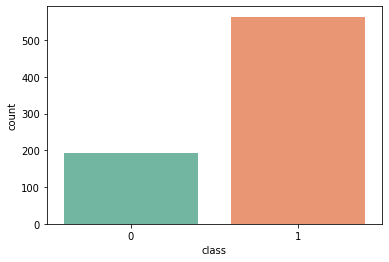

In [3]:
sns.countplot(df['class'], palette = 'Set2')

### Split Input and Traget Variables

In [4]:
X = df.drop('class', axis = 1) 
y = df['class']

In [5]:
X.columns

Index(['imf_snr_seo', 'std_9th_delta', 'tqwt_entropy_shannon_dec_25',
       'tqwt_entropy_log_dec_28', 'tqwt_entropy_log_dec_33',
       'tqwt_tkeo_std_dec_19', 'tqwt_meanvalue_dec_5', 'tqwt_meanvalue_dec_22',
       'tqwt_meanvalue_dec_36', 'tqwt_minvalue_dec_25', 'tqwt_maxvalue_dec_13',
       'tqwt_maxvalue_dec_17', 'tqwt_kurtosisvalue_dec_27',
       'tqwt_kurtosisvalue_dec_31', 'tqwt_kurtosisvalue_dec_33'],
      dtype='object')

### Train Test Split

In [6]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (756, 16)
Shape of training dataset: (604, 15)
Shape of testing dataset: (152, 15)


## Oversampling the minor class

In [7]:
def ovsample(X_train, y_train):
    
    # 'resample' is located under sklearn.utils
    from sklearn.utils import resample
    
    # concatenate training data back together
    train_data = pd.concat([X_train, y_train], axis = 1)

    # separate minority and majority class
    not_par = train_data[train_data['class']==0]
    Parkinsons = train_data[train_data['class']==1]

    # we are oversampling the minority class to match the number of majority classs
    Parkinsons_oversampled = resample(not_par,
                           replace = True, # Sample with replacement
                           n_samples = len(Parkinsons), # Match number in majority class
                           random_state=27)

    # combine majority and upsampled minority
    oversampled = pd.concat([Parkinsons, Parkinsons_oversampled])

    X_train_ov = oversampled.drop('class', axis = 1) 
    y_train_ov = oversampled['class']
    
    return X_train_ov, y_train_ov

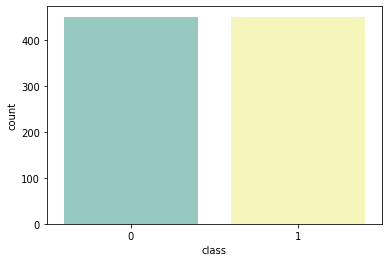

In [8]:
X_train, y_train = ovsample(X_train, y_train)
sns.countplot(y_train, palette = 'Set3')

## Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Defining all the functions

#### Writing a function that returns the evaluation metrics as a DataFrame

In [10]:
def model_comparison(models =[], model_names= []):
    
    acc = []
    prec = []
    recal = []
    f1_train = []
    f1_test = []
    roc_auc = []
    pr_auc = []
    
    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
        pred_prob = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)

        
        f1_train.append(f1_score(y_hat_train, y_train))
        f1_test.append(f1_score(y_hat, y_test))
        acc.append(accuracy_score(y_hat, y_test))
        prec.append(precision_score(y_hat, y_test))
        recal.append(recall_score(y_hat, y_test))
        roc_auc.append(roc_auc_score(y_test, y_hat))
        pr_auc.append(auc(recall, precision))
        
    compare = pd.DataFrame({'Algorithm' : model_names , 'ROC_AUC': roc_auc, 'PR_AUC': pr_auc, 'Precision': prec, 'Recall': recal, 'F1_Train': f1_train, 'F1_Test': f1_test, 'Accuracy' : acc, })
    return compare

#### Writing a function returns Macro and Weighted average of Recall Score

In [11]:
def macro_weighted(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", rec)

    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)

#### Writing a function returns Macro and Weighted average of Recall Score, Precision, and F1 Score

In [12]:
def macro_weighted_prec_rec(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", rec)
    
    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)
    
    print ('.')
    
    prec_mac = metrics.precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", prec_mac)

    prec_wei = metrics.precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", prec_wei)

    f1_mac = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", f1_mac)

    f1_wei = metrics.f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", f1_wei)
    
    print ('.')

#### Performance of the Tarining & Test Set

In [13]:
def f1_acc(y_test, y_hat, y_train, y_hat_train): 
    
    acc_train = metrics.accuracy_score(y_train, y_hat_train)
    print ("Accuracy Score of Train Set:", acc_train)
    
    acc_test = metrics.accuracy_score(y_test, y_hat)
    print ("Accuracy Score of Test Set:", acc_test)
    
    print ('.')
    
    f1_train = metrics.f1_score(y_train, y_hat_train, average = 'macro')
    print ("F1 Score of Train Set:", f1_train)
    
    f1_test = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("F1 Score of Test Set:", f1_test)
    
    ax1 = sns.distplot(y_train, hist=False, color='pink', kde_kws={'bw':0.1}, label = 'Train Data')
    sns.distplot(y_hat_train, hist=False, ax=ax1, color='lightblue', kde_kws={'bw':0.1}, label = 'Predicted Data')
    
    plt.title('Actual vs Predicted Values for Diagnosis (Training Set)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Proportion of Results')
    plt.legend()
    plt.show()
    
    ax2 = sns.distplot(y_test, hist=False, color='salmon', kde_kws={'bw':0.1}, label = 'Test Data')
    sns.distplot(y_hat, hist=False, ax=ax2, color='lightblue', kde_kws={'bw':0.1}, label = 'Predicted Result')
    plt.title('Actual vs Predicted Values for Diagnosis (Test Set)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Proportion of Results')
    plt.legend()
    plt.show()

#### ROC_AUC, Precision Recall AUC and the Confusion Matrices

In [14]:
def roc_pr_cm(models=[]):
    
    roc_auc = []
    pr_auc = []

    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
    
        # predict probabilities
        pred_prob = clf.predict_proba(X_test)
    
        # Print the confusion matrix
        print('---------------------------------------------------------------')
        
        data = confusion_matrix(y_test, y_hat)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (6, 4))
        #sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
        plt.show()
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

        # Print the precision and recall, among other metrics
        print('---------------------------------------------------------------')
        print(metrics.classification_report(y_test, y_hat, digits=3))
        
        print('---------------------------------------------------------------')
        
        macro_weighted(y_test, y_hat)
        
        print('---------------------------------------------------------------')
     
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:, 1], pos_label=1)
        roc_auc.append(roc_auc_score(y_test, y_hat))
    
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        # plot roc curves
        plt.plot(fpr, tpr, label = models[model])
    
        plt.title('ROC curve where AUC= {}'.format(roc_auc[model]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')

        plt.legend(loc='best')
        plt.savefig('ROC', dpi=300)
        plt.show();
    
        # calculate model precision-recall curve
        # precision, recall, _ = precision_recall_curve(y_hat , y_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)
        pr_auc.append(auc(recall, precision))
    
        # plot the model precision-recall curve
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        plt.plot(recall, precision, marker='.', label = models[model])
        plt.title('Precision Recall curve AUC= {}'.format(pr_auc[model]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='best')
        plt.show()

## Final Model

In [15]:
models = [LGBMClassifier(random_state = 42)]
model_names=['LGBMClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,LGBMClassifier,0.79386,0.946082,0.95614,0.886179,1.0,0.919831,0.875


---------------------------------------------------------------


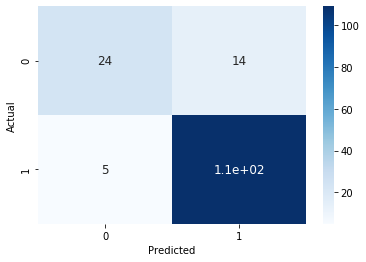

TP: 109, FP: 14, TN: 24, FN: 5
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.828     0.632     0.716        38
           1      0.886     0.956     0.920       114

    accuracy                          0.875       152
   macro avg      0.857     0.794     0.818       152
weighted avg      0.872     0.875     0.869       152

---------------------------------------------------------------
Recall Score: 0.956140350877193
Macro Average of Recall Score: 0.7938596491228069
Weighted Average of Recall Score: 0.875
---------------------------------------------------------------


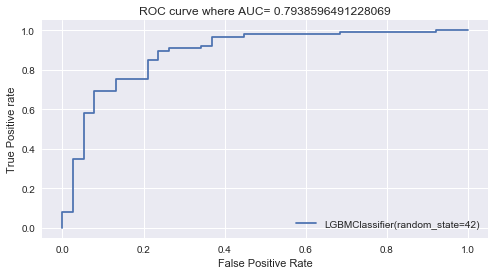

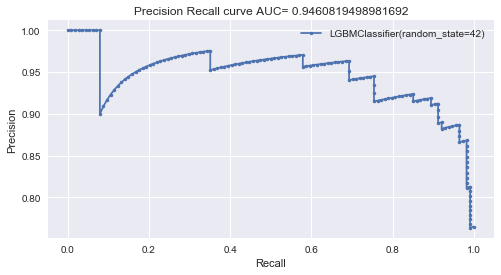

In [16]:
models = [LGBMClassifier(random_state = 42)]
roc_pr_cm(models)

Recall Score: 0.956140350877193
Macro Average of Recall Score: 0.7938596491228069
Weighted Average of Recall Score: 0.875
.
Macro Average of Precision Score: 0.8568825343425848
Weighted Average of Precision Score: 0.8715306980656014
Macro Average of F1 Score: 0.8181245670382264
Weighted Average of F1 Score: 0.8689778953334593
.
Accuracy Score of Train Set: 1.0
Accuracy Score of Test Set: 0.875
.
F1 Score of Train Set: 1.0
F1 Score of Test Set: 0.8181245670382264


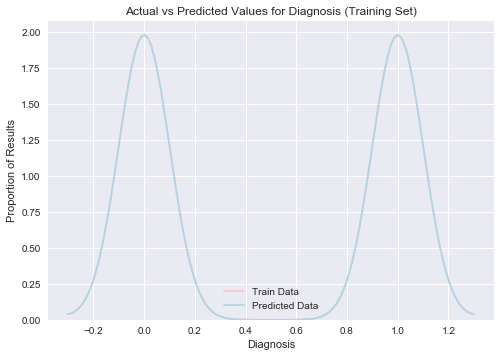

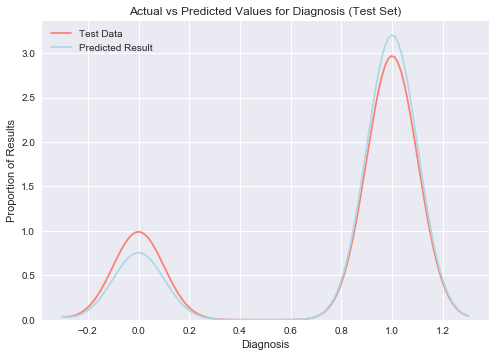

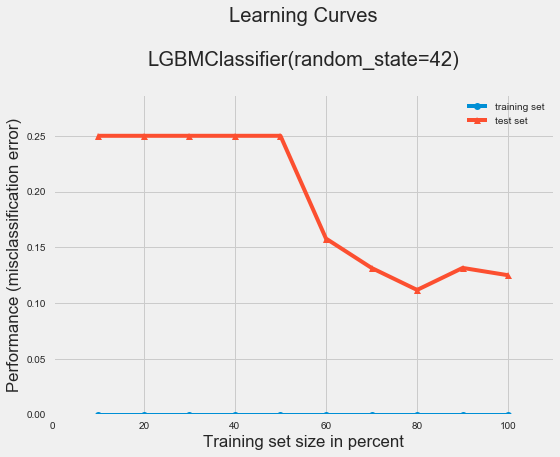

In [17]:
from sklearn import model_selection
from pprint import pprint

model = LGBMClassifier(random_state = 42)

model.fit(X_train, y_train)
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

macro_weighted_prec_rec(y_test, y_hat)

f1_acc(y_test, y_hat, y_train, y_hat_train)

from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, model)
plt.show()

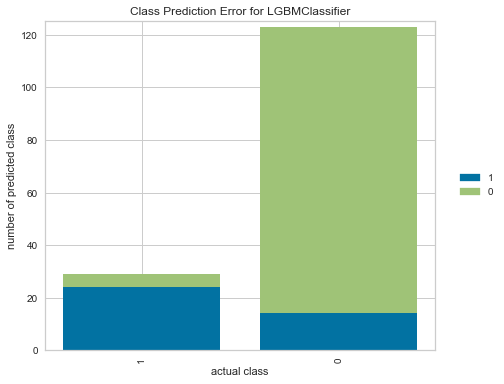

In [18]:
classes = [1, 0]

from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(
    LGBMClassifier(random_state = 42), classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### Let's fit the whole data now to predict result from user input.

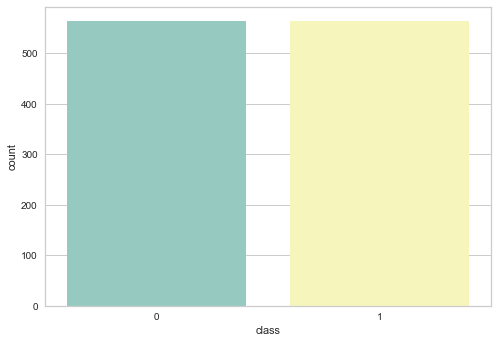

In [19]:
features = ['tqwt_entropy_log_dec_33', 'tqwt_minvalue_dec_25',
 'tqwt_entropy_shannon_dec_25', 'tqwt_meanvalue_dec_36',
 'tqwt_kurtosisvalue_dec_33', 'tqwt_kurtosisvalue_dec_31',
 'tqwt_maxvalue_dec_17', 'std_9th_delta', 'tqwt_maxvalue_dec_13',
 'tqwt_entropy_log_dec_28', 'tqwt_tkeo_std_dec_19', 'tqwt_meanvalue_dec_22',
 'imf_snr_seo', 'tqwt_meanvalue_dec_5', 'tqwt_kurtosisvalue_dec_27', 'class']

df = pd.read_csv('preprocessed_speech_features.csv', usecols = features)

X = df.drop('class', axis = 1) 
y = df['class']

X, y = ovsample(X, y)
sns.countplot(y, palette = 'Set3')

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [21]:
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(X, y)

LGBMClassifier(random_state=42)

In [22]:
import pickle 
# open a file, where you ant to store the data
file = open('lgbm_parkinsons.pkl', 'wb')

# dump information to that file
pickle.dump(lgbm, file)